In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os

1. Drop (remove) the following features
These either have very high missingness, duplicate information, or low relevance:

ORG_AR (redundant with WL_ORG)

REC_TX_PROCEDURE_TY (≈46 % missing)

DON_TY (low relevance)

REC_TX_DT (duplicate transplant date)

CAN_PREV_KI_TX_FUNCTN (≈99 % missing)

CAN_MALIG_TY (≈94 % missing)

CAN_CMV_STAT (≈99.9 % missing)

CAN_CREAT_CLEAR & CAN_CREAT_CLEAR_DT (≈96 % missing)

CAN_DIAB (78 % missing; superseded by CAN_DIAB_TY)

CAN_DIAL_DT (exact dialysis date not needed)

CAN_ANGINA (78 % missing; keep only the simpler CAD flag)

CAN_REM_COD (91 % missing cause‐of‐death codes)

2. Keep (retain) the following core features
All other columns carry essential demographic, clinical or laboratory information:

Identifiers: PX_ID, PERS_ID

Wait-list metadata: CAN_SOURCE, WL_ORG

Donor link: DONOR_ID

Demographics: CAN_AGE_AT_LISTING, CAN_GENDER, CAN_RACE, CAN_RACE_SRTR

Anthropometry & labs: CAN_BMI, CAN_MIN_FINAL_CREAT, CAN_MIN_PEAK_CREAT, CAN_TOT_ALBUMIN, CAN_MOST_RECENT_CREAT, HLA A/B/DR (see Folder for details), PRA (see folder for details)

Clinical status: CAN_FUNCTN_STAT, CAN_INIT_STAT, CAN_DGN, CAN_PREV_KI, CAN_PERIPH_VASC, CAN_MALIG, CAN_ACTIVATE_DT

Event dates: CAN_LISTING_DT, PERS_NEXTTX (transplant date), CAN_DEATH_DT

Key flags: CAN_ANGINA_CAD, CAN_PREV_TXFUS

Active/Inactive Status: CAN_LAST_ACT_STAT_DT, CAN_LAST_INACT_STAT_DT

In [2]:
subset_path = "/Users/chanyoungwoo/Thesis/Data_Extraction/extracted_subsets/cand_kipa_subset.csv"
cand = pd.read_csv(subset_path)

/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_1729/2431972163.py:2: DtypeWarning: Columns (6,8,12,14,16,25,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  cand = pd.read_csv(subset_path)


In [3]:
to_drop = [
    "ORG_AR",
    "REC_TX_PROCEDURE_TY", "DON_TY",
    "REC_TX_DT", "CAN_PREV_KI_TX_FUNCTN",
    "CAN_MALIG_TY", "CAN_CMV_STAT",
    "CAN_CREAT_CLEAR", "CAN_CREAT_CLEAR_DT",
    "CAN_DIAB", "CAN_DIAL_DT",
    "CAN_ANGINA", "CAN_REM_COD",
]

In [4]:
cand_clean = cand.drop(columns=to_drop)
print(f"Shape before: {cand.shape}, after drop: {cand_clean.shape}")
cand_clean.head()

Shape before: (1199290, 52), after drop: (1199290, 39)


,PERS_ID,PX_ID,WL_ORG,CAN_GENDER,CAN_RACE,CAN_RACE_SRTR,CAN_ACTIVATE_DT,CAN_LISTING_DT,CAN_SOURCE,CAN_DEATH_DT,...,CAN_AGE_AT_LISTING,CAN_PREV_KI,CAN_INIT_SRTR_PEAK_PRA,CAN_INIT_CUR_PRA,CAN_INIT_ALLOC_PRA,CAN_INIT_STAT,CAN_LAST_ACT_STAT_DT,CAN_LAST_INACT_STAT_DT,PERS_NEXTTX,DONOR_ID
0,2958459.0,-1994541.0,KI,M,8.0,WHITE,1996-01-24,1993-01-13,R,NaN,...,35.0,0.0,4.0,4.0,4.0,4010.0,1997-05-01,NaN,1997-02-12,NaN
1,2954395.0,-1993046.0,KI,M,16.0,BLACK,1992-12-22,1992-12-22,R,1996-11-05,...,37.0,1.0,99.0,80.0,99.0,4010.0,1994-11-07,1996-11-05,NaN,NaN
2,2176016.0,-1980295.0,KI,F,16.0,BLACK,1993-02-01,1993-02-01,R,NaN,...,51.0,0.0,13.0,13.0,13.0,4010.0,1994-09-22,1997-04-11,NaN,NaN
3,2670483.0,-1996133.0,KI,M,32.0,NATIVE,1992-11-23,1992-11-23,R,NaN,...,31.0,0.0,0.0,0.0,0.0,4010.0,1994-12-27,1995-07-05,1995-12-02,NaN
4,2919390.0,-1979910.0,KI,M,8.0,WHITE,1992-12-16,1992-12-16,R,1997-12-24,...,53.0,0.0,0.0,0.0,NaN,4010.0,1997-11-03,1997-12-24,NaN,NaN


,missing_pct
CAN_DEATH_DT,88.657789
CAN_PREV_TXFUS,78.433490
CAN_INIT_ALLOC_PRA,75.566710
CAN_ANGINA_CAD,72.501647
CAN_INIT_CUR_PRA,68.113384
CAN_INIT_SRTR_PEAK_PRA,67.623677
CAN_MOST_RECENT_CREAT,65.497002
CAN_LAST_INACT_STAT_DT,51.717016
CAN_DIAL,48.990486
DONOR_ID,46.526445


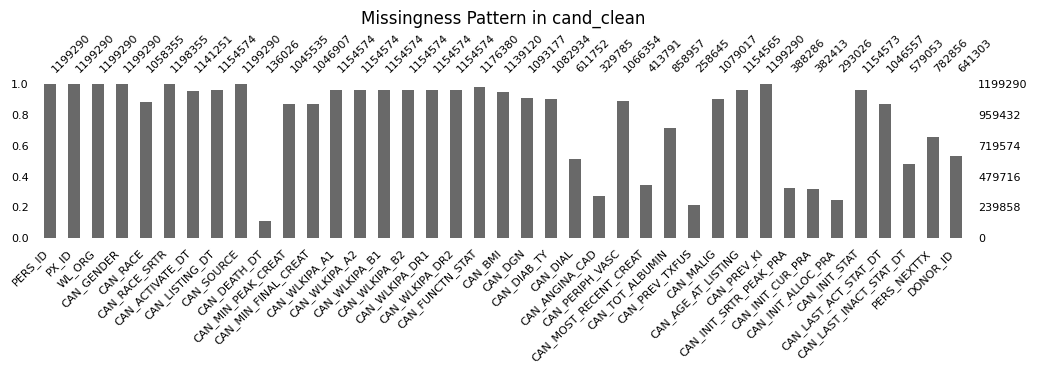

In [ ]:
miss_pct = cand_clean.isna().mean().mul(100).sort_values(ascending=False)
missingness_df = miss_pct.to_frame(name="missing_pct")

display(missingness_df)

plt.figure(figsize=(12, 2))
msno.bar(cand_clean, fontsize=8, figsize=(12, 2))
plt.title("Misssingness Pattern in cand_clean")
plt.show()

In [6]:
OUT_DIR = "/Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver1"
os.makedirs(OUT_DIR, exist_ok=True)

# write cand_clean to CSV
out_path = os.path.join(OUT_DIR, "cand_kipa_clean.csv")
cand_clean.to_csv(out_path, index=False)
print(f"Saved cleaned CAND_KIPA subset to {out_path}")

Saved cleaned CAND_KIPA subset to /Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver1/cand_kipa_clean.csv
